In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr

In [2]:
df_transactions_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "Thalia_transactions_ohne_vorname.csv")

df_history_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "Thalia_history_ohne_vorname.csv")

In [3]:
df_privatkunden_iids = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/" +
                                    "privatkunden.iid.thalia.csv", index_col = [0])

# 1. Daten bereinigen

#### 1.1 Transaktions-Daten bereinigen

In [4]:
df_t_bereinigt = df_transactions_wofirstname[["iid", "key", "attrtype", "status", "pricetotal", "createdprovider"]]
#df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")
df_t_bereinigt = df_t_bereinigt.query('attrtype == "TI"')
df_t_bereinigt = df_t_bereinigt.query('status == "Buchung" or status == "Order"')
df_t_bereinigt = df_t_bereinigt.query('pricetotal >= 0.01')
#searchfor = ['TEST']
#searchfor = ['TEST', 'JET', "WS"]
#df_t_bereinigt = df_t_bereinigt[~df_t_bereinigt["key"].str.contains('|'.join(searchfor))]
df_t_bereinigt.head()

,iid,key,attrtype,status,pricetotal,createdprovider
1,100279806,JET_1_a1179092,TI,Order,20.5,20220630111759
4,262428540,JET_1_a1179095,TI,Order,5.0,20220630113800
5,262429050,JET_1_a1179096,TI,Order,20.5,20220630115500
7,262429050,JET_1_a1179096,TI,Order,9.0,20220630115500
10,262429655,JET_1_a1179100,TI,Order,55.0,20220630121500


In [5]:
df_transactions_wofirstname.head()

,mandator,id,iid,attrtype,key,itemkey,status,productid,productname,modifiedprovider,createdprovider,startdate,quantity,discountname,saleschannelname,price,discountgroup,discountamount,pricetotal
0,100000490,262615460,100279806,OR,JET_1_a1179092,NaN,Order,NaN,NaN,20220701153023,20220630111759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100000490,262615461,100279806,TI,JET_1_a1179092,JET_1_a1179092_1_1_0,Order,JET_1_3941,Maria Stuart und Elisabeth,20220701153023,20220630111759,2.022063e+13,1.0,NaN,Kasse,20.5,NaN,NaN,20.5
2,100000490,262617949,101270948,OR,JET_1_a1179145,NaN,Order,NaN,NaN,20220701153507,20220630135500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100000490,262616022,262428540,OR,JET_1_a1179095,NaN,Order,NaN,NaN,20220701153131,20220630113800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100000490,262616023,262428540,TI,JET_1_a1179095,JET_1_a1179095_1_1_0,Order,JET_1_3618,book.beat,20220701153131,20220630113800,2.022063e+13,1.0,NaN,Gateway,5.0,NaN,NaN,5.0


In [6]:
df_transactions_wofirstname["createdprovider"].min()

20050712145407

In [7]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_transactions_wofirstname.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_t_bereinigt.index)))

Anzahl Einträge ohne Bereinigung: 1925405
Anzahl Einträge mit Bereinigung: 1236067


#### 1.2 Historien-Daten bereinigen
##### ausschließlich Öffungen als Interaktionen betrachtet

In [8]:
df_h_bereinigt = df_history_wofirstname[["iid", "attrtype", "akey",  "creation"]]
df_h_bereinigt = df_h_bereinigt.query('attrtype == "NO" or attrtype == "HY"')
df_h_bereinigt.head()

,iid,attrtype,akey,creation
0,100253777,NO,240805772,20220330211124
1,100256545,NO,240805772,20220330204021
2,100083508,NO,232751147,20220330204142
3,100256545,NO,240805772,20220330204152
4,100922912,NO,227354388,20220330204217


In [9]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_history_wofirstname.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_h_bereinigt.index)))

Anzahl Einträge ohne Bereinigung: 4854430
Anzahl Einträge mit Bereinigung: 4571990


# 2. Privatkunden iids mit Transaktionsdaten mergen

#### 2.1 ... für Transaktionsdaten

In [10]:
df_t_merged = pd.merge(df_t_bereinigt, df_privatkunden_iids, on = ["iid"])
df_t_merged.head()

,iid,key,attrtype,status,pricetotal,createdprovider
0,100279806,JET_1_a1179092,TI,Order,20.5,20220630111759
1,100279806,JET_1_a1192486,TI,Order,25.0,20220924182326
2,100279806,JET_1_a1192486,TI,Order,25.0,20220924182326
3,100279806,JET_1_a1064841,TI,Buchung,28.9,20200904205800
4,100279806,JET_1_a1064841,TI,Buchung,28.9,20200904205800


In [11]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_t_bereinigt.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_t_merged.index)))

Anzahl Einträge ohne Bereinigung: 1236067
Anzahl Einträge mit Bereinigung: 835238


#### 2.2 ... für Historiendaten

In [12]:
df_h_merged = pd.merge(df_h_bereinigt, df_privatkunden_iids, on = ["iid"])
df_h_merged.head()

,iid,attrtype,akey,creation
0,100256545,NO,240805772,20220330204021
1,100256545,NO,240805772,20220330204152
2,100256545,NO,284987833,20221117172146
3,100256545,NO,284987833,20221117173447
4,100256545,NO,207410494,20220212170553


In [13]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_h_bereinigt.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_h_merged.index)))

Anzahl Einträge ohne Bereinigung: 4571990
Anzahl Einträge mit Bereinigung: 2612931


# 3 Datum als datetime type und rename

#### 3.1 Createdprovider als datetime type und rename

In [14]:
df_t_datetime = df_t_merged
df_t_datetime["createdprovider"] = pd.to_datetime(df_t_datetime['createdprovider'], format='%Y%m%d%H%M%S')
df_t_datetime.rename(columns = {"createdprovider" : "date"}, inplace = True)
df_t_datetime.head()

,iid,key,attrtype,status,pricetotal,date
0,100279806,JET_1_a1179092,TI,Order,20.5,2022-06-30 11:17:59
1,100279806,JET_1_a1192486,TI,Order,25.0,2022-09-24 18:23:26
2,100279806,JET_1_a1192486,TI,Order,25.0,2022-09-24 18:23:26
3,100279806,JET_1_a1064841,TI,Buchung,28.9,2020-09-04 20:58:00
4,100279806,JET_1_a1064841,TI,Buchung,28.9,2020-09-04 20:58:00


#### 3.2 creation als datetime type und rename

In [15]:
df_h_datetime = df_h_merged
df_h_datetime["creation"] = pd.to_datetime(df_h_datetime['creation'], format='%Y%m%d%H%M%S')
df_h_datetime.rename(columns = {"creation" : "date"}, inplace = True)
df_h_datetime.head()

,iid,attrtype,akey,date
0,100256545,NO,240805772,2022-03-30 20:40:21
1,100256545,NO,240805772,2022-03-30 20:41:52
2,100256545,NO,284987833,2022-11-17 17:21:46
3,100256545,NO,284987833,2022-11-17 17:34:47
4,100256545,NO,207410494,2022-02-12 17:05:53


# 4. Status, key und attrtype droppen für Transaktionsdaten, da redundant

In [16]:
df_t_ohne_redundanz = df_t_datetime[["iid", "pricetotal", "date"]]
df_t_ohne_redundanz.head()

,iid,pricetotal,date
0,100279806,20.5,2022-06-30 11:17:59
1,100279806,25.0,2022-09-24 18:23:26
2,100279806,25.0,2022-09-24 18:23:26
3,100279806,28.9,2020-09-04 20:58:00
4,100279806,28.9,2020-09-04 20:58:00


# 5. #empfangene NL, #oeffnungen und oeffnungsrate zu df_h hinzufügen

In [17]:
df_h_bearbetiung5 = df_h_datetime
df_h_bearbetiung5.head()

,iid,attrtype,akey,date
0,100256545,NO,240805772,2022-03-30 20:40:21
1,100256545,NO,240805772,2022-03-30 20:41:52
2,100256545,NO,284987833,2022-11-17 17:21:46
3,100256545,NO,284987833,2022-11-17 17:34:47
4,100256545,NO,207410494,2022-02-12 17:05:53


#### 5.1 Anzahl Oeffnungen pro iid ermitteln

In [18]:
df_h_oeffnungen = df_h_bearbetiung5[df_h_bearbetiung5["attrtype"] == "NO"].groupby(["iid"]).agg("count")
df_h_oeffnungen = df_h_oeffnungen["attrtype"].to_frame().reset_index().rename(columns = {"attrtype": "#Oeffnungen"})
df_h_oeffnungen.head()

,iid,#Oeffnungen
0,100002747,5
1,100011333,28
2,100011954,65
3,100013945,3
4,100016146,19


#### 5.2 Anzahl empfangene Newsletter pro iid ermitteln

In [19]:
df_h_versendet = df_h_bearbetiung5[df_h_bearbetiung5["attrtype"] == "HY"].groupby(["iid"]).agg("count")
df_h_versendet = df_h_versendet["attrtype"].to_frame().reset_index().rename(columns = {"attrtype": "#empfangen"})
df_h_versendet.head()

,iid,#empfangen
0,100002747,36
1,100009615,42
2,100011333,65
3,100011954,57
4,100013175,35


#### 5.3 #empfangen und #oeffungen in df überführen

In [20]:
df_h_oeffnungsrate = pd.merge(df_h_datetime, df_h_oeffnungen, on = ["iid"])
df_h_oeffnungsrate = pd.merge(df_h_oeffnungsrate, df_h_versendet, on = ["iid"])
df_h_oeffnungsrate["oeffnungsrate"] = df_h_oeffnungsrate["#Oeffnungen"] / df_h_oeffnungsrate["#empfangen"]
df_h_oeffnungsrate.head()

,iid,attrtype,akey,date,#Oeffnungen,#empfangen,oeffnungsrate
0,100256545,NO,240805772,2022-03-30 20:40:21,331,136,2.433824
1,100256545,NO,240805772,2022-03-30 20:41:52,331,136,2.433824
2,100256545,NO,284987833,2022-11-17 17:21:46,331,136,2.433824
3,100256545,NO,284987833,2022-11-17 17:34:47,331,136,2.433824
4,100256545,NO,207410494,2022-02-12 17:05:53,331,136,2.433824


# 6. Korrelation Öffnungsrate und Costumer Value von Kunden seit Einführung der EMS

#### 6.1 Ermittlung des Einführungs-Datums der EMS anhand erster versandter NL

In [21]:
einfuehrung = pd.to_datetime(df_history_wofirstname["creation"].min(), format='%Y%m%d%H%M%S')
einfuehrung

Timestamp('2020-04-02 14:00:03')

#### 6.2 Reduktion der Transdaten auf Daten nach Einführung der EMS

In [22]:
df_t_seit_einfuehrung = df_t_ohne_redundanz.query('date >= @einfuehrung')
df_t_seit_einfuehrung.head()

,iid,pricetotal,date
0,100279806,20.5,2022-06-30 11:17:59
1,100279806,25.0,2022-09-24 18:23:26
2,100279806,25.0,2022-09-24 18:23:26
3,100279806,28.9,2020-09-04 20:58:00
4,100279806,28.9,2020-09-04 20:58:00


#### 6.3 Ermittlung des Costumer Value pro iid

In [23]:
df_t_CV = df_t_seit_einfuehrung.groupby(['iid'])['pricetotal'].agg('sum').to_frame().reset_index()
df_t_CV.head()

,iid,pricetotal
0,100002747,155.0
1,100011333,172.0
2,100011954,397.8
3,100016146,22.0
4,100021341,145.0


#### 6.4 Oeffnungsrate zu df mit CV hinzufügen

In [24]:
df_h_oeffnungsrate_reduziert = df_h_oeffnungsrate[["iid", "oeffnungsrate"]]
df_korrelation = pd.merge(df_t_CV, df_h_oeffnungsrate_reduziert, on = ["iid"])
df_korrelation = df_korrelation.drop_duplicates()
df_korrelation.head()

,iid,pricetotal,oeffnungsrate
0,100002747,155.0,0.138889
41,100011333,172.0,0.430769
134,100011954,397.8,1.140351
256,100016146,22.0,0.296875
339,100021341,145.0,0.272727


#### 6.5 Berechnung der Korrelation

In [25]:
correlation = df_korrelation[["pricetotal", "oeffnungsrate"]].corr(method='pearson')
print("Korrelation zwischen pricetotal und oeffnungsrate")
correlation

#sns.heatmap(df_korrelation[["pricetotal", "oeffnungsrate"]].corr(method='pearson'),annot=True)

Korrelation zwischen pricetotal und oeffnungsrate


,pricetotal,oeffnungsrate
pricetotal,1.000000,0.057263
oeffnungsrate,0.057263,1.000000


# 7. Korrelation Öffnungsrate und Costumer Value von Kunden seit Einführung der EMS mit standardisierten Variablen

In [26]:
df_korrelation[["pricetotal_standard","oeffnungsrate_standard"]] =\
            (df_korrelation[["pricetotal","oeffnungsrate"]] - df_korrelation[["pricetotal","oeffnungsrate"]].mean())\
            /df_korrelation[["pricetotal","oeffnungsrate"]].std()
df_korrelation.head()

,iid,pricetotal,oeffnungsrate,pricetotal_standard,oeffnungsrate_standard
0,100002747,155.0,0.138889,0.396592,-0.677056
41,100011333,172.0,0.430769,0.516634,-0.575405
134,100011954,397.8,1.140351,2.111075,-0.328284
256,100016146,22.0,0.296875,-0.542560,-0.622035
339,100021341,145.0,0.272727,0.325979,-0.630445


In [27]:
corr = df_korrelation['pricetotal_standard'].corr(df_korrelation['oeffnungsrate_standard'])
print("Korrelation zwischen pricetotal und oeffnungsrate")
corr

Korrelation zwischen pricetotal und oeffnungsrate


0.057262822673302495

# 8. Betrachtung der Korrelation für verschiedene Gruppen von Kunden (Einteilung über den CV der vorangegegangenen 5 Jahren)
#### Idee: die geringe Korrelation hat möglicherweise damit zu tun, dass es viele "Einmalkunden" gibt

#### 8.1 Hinzufügen einer Spalte "CV_letzte_5_jahre" zu den trans df

In [28]:
datum_vor_5_jahren = einfuehrung - timedelta(days=365*5)
df_t_5_Jahre_davor = df_t_ohne_redundanz.query('@datum_vor_5_jahren <= date <= @einfuehrung')
df_t_5_Jahre_davor.head()

,iid,pricetotal,date
16,100520650,11.4,2020-03-02 10:00:00
22,100520650,18.9,2016-11-04 14:00:05
23,100520650,18.9,2017-03-09 10:30:00
24,100520650,20.6,2017-04-22 16:34:46
25,100520650,18.0,2017-04-22 16:34:46


In [29]:
df_t_5_Jahre_davor_CV = df_t_5_Jahre_davor.groupby(['iid'])['pricetotal'].agg('sum').to_frame().reset_index()
df_t_5_Jahre_davor_CV.rename(columns = {"pricetotal":"CV_letzte_5_jahre"}, inplace = True)
df_t_5_Jahre_davor_CV.head()

,iid,CV_letzte_5_jahre
0,100009615,131.6
1,100011954,763.6
2,100013945,74.7
3,100017834,15.0
4,100022607,41.0


In [30]:
df_t_5_Jahre_davor_CV = pd.merge(df_korrelation[["iid", "pricetotal", "oeffnungsrate"]], df_t_5_Jahre_davor_CV, on = ["iid"])
df_t_5_Jahre_davor_CV.head()

,iid,pricetotal,oeffnungsrate,CV_letzte_5_jahre
0,100011954,397.8,1.140351,763.6
1,100046320,119.7,0.061224,128.4
2,100057001,126.9,1.666667,18.0
3,100057363,103.5,0.695652,50.0
4,100057681,1007.6,0.636364,62.0


#### 8.3 Korrelation in Abhängigkeit von CV

<AxesSubplot:xlabel='obergrenze'>

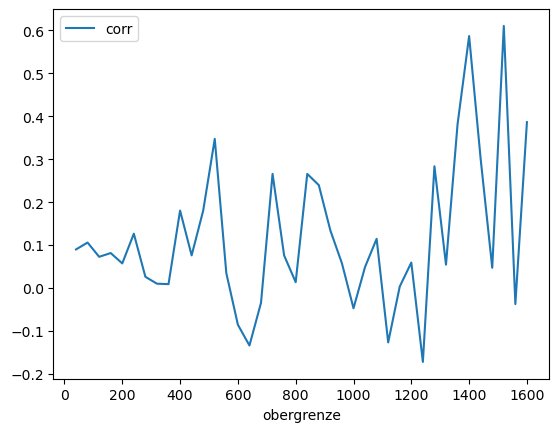

In [31]:
# Erstelle leeren DataFrame
df_korrelation_mit_CV_davor_zusammen = pd.DataFrame()
# Liste zum Sammeln der neuen Zeilen
rows = []

for i in range(40):
    schritte = 40
    darunter = schritte * i
    darüber = schritte * (i + 1)
    df_korrelation_mit_CV_davor = df_t_5_Jahre_davor_CV.query("@darunter <= CV_letzte_5_jahre <= @darüber")
    corr = df_korrelation_mit_CV_davor['pricetotal'].corr(df_korrelation_mit_CV_davor['oeffnungsrate'])
    data = {'obergrenze': darüber, 'corr': corr}
    rows.append(data)

df_korrelation_mit_CV_davor_zusammen = pd.DataFrame(rows)
df_korrelation_mit_CV_davor_zusammen.plot(x = "obergrenze", y = "corr")

<AxesSubplot:xlabel='obergrenze'>

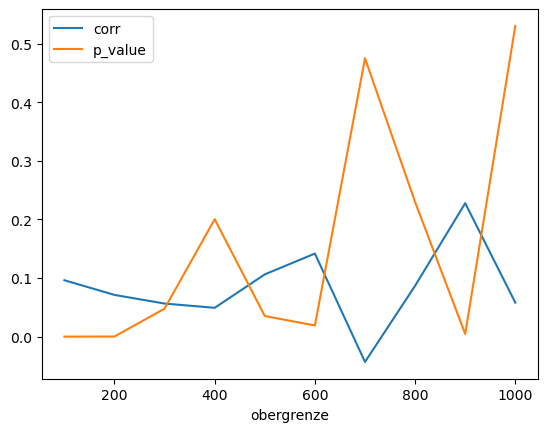

In [32]:
# Erstelle leeren DataFrame
df_korrelation_pValue_mit_CV_davor_zusammen = pd.DataFrame()
# Liste zum Sammeln der neuen Zeilen
rows = []

for i in range(10):
    schritte = 100
    darunter = schritte * i
    darüber = schritte * (i + 1)
    df_korrelation_mit_CV_davor = df_t_5_Jahre_davor_CV.query("@darunter <= CV_letzte_5_jahre <= @darüber")
    r, p_value = pearsonr(df_korrelation_mit_CV_davor['pricetotal'], df_korrelation_mit_CV_davor['oeffnungsrate'])
    data = {'obergrenze': darüber, 'corr': r, "p_value": p_value}
    rows.append(data)

df_korrelation_pValue_mit_CV_davor_zusammen = pd.DataFrame(rows)
df_korrelation_pValue_mit_CV_davor_zusammen.plot(x = "obergrenze", y = ["corr", "p_value"])

array([[<AxesSubplot:title={'center':'iid'}>,
        <AxesSubplot:title={'center':'pricetotal'}>],
       [<AxesSubplot:title={'center':'oeffnungsrate'}>,
        <AxesSubplot:title={'center':'CV_letzte_5_jahre'}>]], dtype=object)

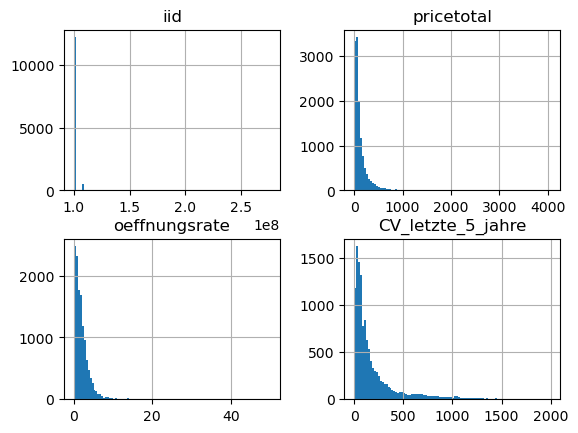

In [33]:
df_t_5_Jahre_davor_CV[df_t_5_Jahre_davor_CV["CV_letzte_5_jahre"] < 2000].hist(bins = 100)

#### 8.5 Verteilung von pricetotal in Abhängigkeit von voherigen CV

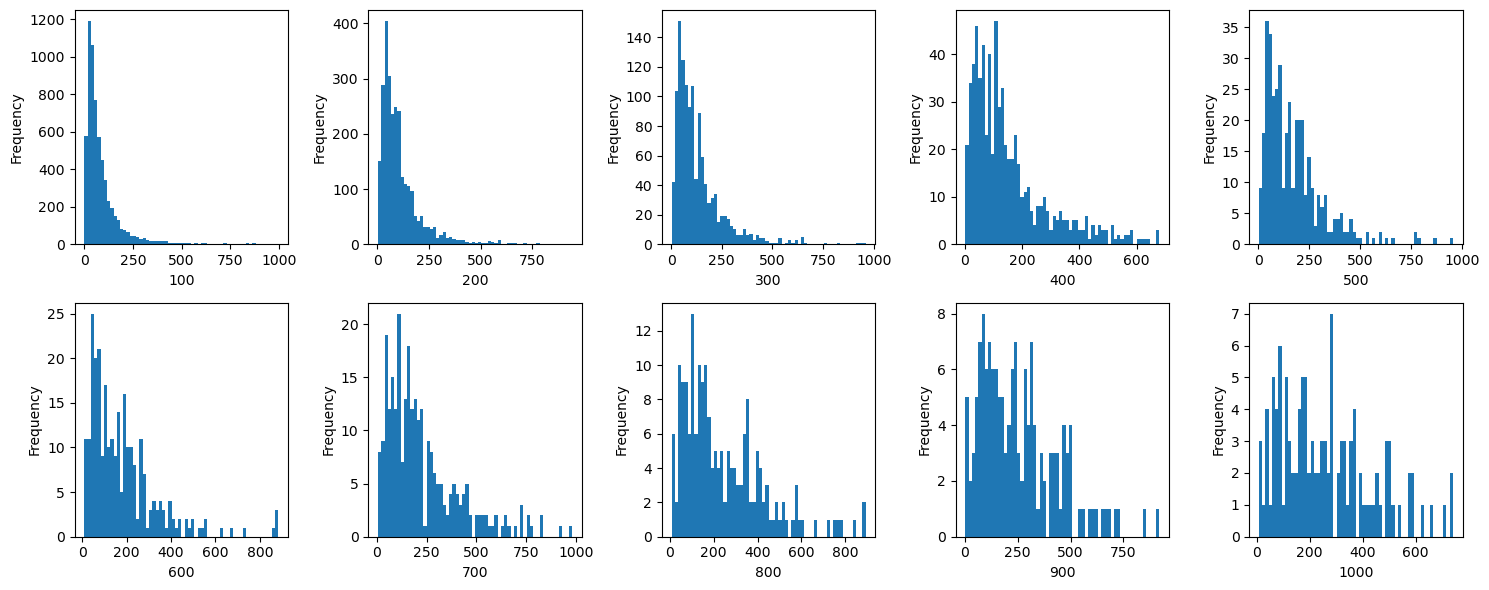

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6), tight_layout=True)
axs = axs.ravel()

for i in range(10):
    schritte = 100
    darunter = schritte * i
    darüber = schritte * (i + 1)
    axs[i].hist(df_t_5_Jahre_davor_CV.query("@darunter <= CV_letzte_5_jahre <= @darüber and pricetotal <= 1000")\
                ["pricetotal"], bins = 60)
    axs[i].set_xlabel(darüber)
    axs[i].set_ylabel('Frequency')
plt.show()